# Imports

In [27]:
import csv
import os
import sys
# Spark imports
from pyspark.rdd import RDD
from pyspark.sql import DataFrame
from pyspark.sql.types import IntegerType
from pyspark.sql import SparkSession
import operator
# Dask imports
import dask.bag as db
import dask.dataframe as df  # you can use Dask bags or dataframes
from csv import reader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import *
import sklearn
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
# from scipy.sparse import csr_matrix
# import scipy as sp
import heapq
# from surprise import CoClustering
# from surprise import Dataset, Reader, SVD, accuracy
# from surprise import KNNBaseline


# Packages for model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from time import time

# from surprise.model_selection import train_test_split
# from sklearn.model_selection import train_test_split

# Package to suppress warnings
import warnings
warnings.filterwarnings("ignore")
from pyspark.sql.functions import monotonically_increasing_id
# Packages for saving models
import pickle

from re import split
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, DoubleType, IntegerType, StringType, DateType
from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor

In [28]:
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Python Spark SQL basic example") \
        .config("spark.some.config.option", "some-value") \
        .getOrCreate()
    return spark

In [29]:
spark=init_spark()

## Generate Data For Base Game DataSet

In [30]:
def generateData():
    path_to_write = parentPath+'/data/datasets'
    originalDataSet = pd.read_csv(parentPath+'/data/datasets/steam.csv')
    if os.path.exists(path_to_write+'/games.csv'):
        return pd.read_csv(path_to_write+'/games.csv')
    for row in originalDataSet.iterrows():
        row =row[1]
        totalRatings = (row['positive_ratings'] + row['negative_ratings'])
        if totalRatings == 0:
            ratings = 0
        else:
            ratings = round((row['positive_ratings']/totalRatings) * 100,2)
        dictionnary[row['appid']] = {
                    "name": row['name'],
                    "price": row['price'],
                    "release_date": row['release_date'],
                    "required_age": row['required_age'],
                    "publishers": row['publisher'],
                    "developers": row['developer'],
                    "categories": row['categories'],
                    "genres": row['genres'],
                    "ratings": ratings,
                    "totalRatings": totalRatings,
                    "average_playtime": row['average_playtime'],
                    "median_playtime": row['median_playtime'],
                    "num_owners": row['owners']
        }
    
    

    df = pd.DataFrame.from_dict(dictionnary, orient='index')
    df.index.name = 'appid'
    if not os.path.exists(path_to_write):
        os.mkdir(path_to_write)
    
    df.to_csv(path_to_write+'/games.csv')
    return df

## Generate the User Steam Dataset

In [31]:
url_user_info = "https://api.steampowered.com/IPlayerService/GetOwnedGames/v1/?key=D399B9CAE07939881781DD36CC8CC442&steamid={}&include_appinfo=true&include_played_free_games=true"
def generateDataForUserSteamDataset():
    dictionary=[]
    path_to_write = parentPath+'/data/datasets'
    if os.path.exists(path_to_write+'/steam_id_games.csv'):
        return pd.read_csv(path_to_write+'/steam_id_games.csv')
    originalDataSet = pd.read_csv(parentPath+'/data/datasets/steam_id.csv')
    for row in originalDataSet.iterrows():
        row =row[1]
        try:
            games = requests.get(url_user_info.format(row['steamid_a'])).json()['response']
        except:
            continue
        if 'games' not in games:
            continue
        dataset = [{'steam_id':row['steamid_a'],"appid" :str(game['appid']), "time_played_in_minutes": game['playtime_forever'] } for game in games['games']]
        dictionary = dataset+dictionary
    df = pd.DataFrame.from_records(dictionary)
    if not os.path.exists(path_to_write):
        os.mkdir(path_to_write)
    
    df.to_csv(path_to_write+'/steam_id_games.csv')
    return df

In [32]:
filename="../data/datasets/games.csv"
filename2="../data/datasets/steam_id_games.csv"

In [33]:
from pyspark.sql.types import *
games_schema = StructType() \
    .add("appid", IntegerType(), True) \
    .add("name", StringType(), True) \
    .add("price", DoubleType(), True) \
    .add("release_date", StringType(), True) \
    .add("required_age", IntegerType(), True) \
    .add("publishers", StringType(), True) \
    .add("developers", StringType(), True) \
    .add("categories", StringType(), True) \
    .add("genres", StringType(), True) \
    .add("ratings", DoubleType(), True) \
    .add("totalRatings", IntegerType(), True) \
    .add("average_playtime", DoubleType(), True) \
    .add("median_playtime", IntegerType(), True) \
    .add("num_owners", StringType(), True)
games = spark.read.schema(games_schema).csv(filename, header=True).dropna()


In [34]:
games.take(5)

[Row(appid=10, name='Counter-Strike', price=7.19, release_date='2000-11-01', required_age=0, publishers='Valve', developers='Valve', categories='Multi-player;Online Multi-Player;Local Multi-Player;Valve Anti-Cheat enabled', genres='Action', ratings=97.39, totalRatings=127873, average_playtime=17612.0, median_playtime=317, num_owners='10000000-20000000'),
 Row(appid=20, name='Team Fortress Classic', price=3.99, release_date='1999-04-01', required_age=0, publishers='Valve', developers='Valve', categories='Multi-player;Online Multi-Player;Local Multi-Player;Valve Anti-Cheat enabled', genres='Action', ratings=83.98, totalRatings=3951, average_playtime=277.0, median_playtime=62, num_owners='5000000-10000000'),
 Row(appid=30, name='Day of Defeat', price=3.99, release_date='2003-05-01', required_age=0, publishers='Valve', developers='Valve', categories='Multi-player;Valve Anti-Cheat enabled', genres='Action', ratings=89.56, totalRatings=3814, average_playtime=187.0, median_playtime=34, num_ow

## Normalization

In [35]:
# normalizer = Normalizer(inputCol="price", outputCol="price")
# myGames = normalizer.transform(myGames)
#hasher = FeatureHasher(inputCols=["price", "release_date", "required_age", "ratings","totalRatings","average_playtime","median_playtime","Action"],
#                       outputCol="features")

#featurized = hasher.transform(myGames)
#listOfGames=featurized.take(100)

#featurized.head()

#myGames3 = myGames.take(10000)
#normalizer = Normalizer(inputCol="features", outputCol="normFeatures", p=1.0)
#l1NormData = normalizer.transform(featurized)
#l1NormData.head()

# lInfNormData = normalizer.transform(featurized, {normalizer.p: float("inf")})
#listOfGames=l1NormData.take(10)
# listOfGames.reshape(-1, 1)
# X_normalized = normalizer(myGames, copy=True)
#type(listOfGames)
#listOfGames=np.array([listOfGames], dtype=object)

## Data Preprocessing

In [36]:
# get the yaer of release_date
games = games.withColumn('release_date', col('release_date')[0:4])
games = games.withColumn("release_date", games["release_date"].cast(IntegerType()))

In [37]:
#create columns for genres
games = games.withColumn('genres', split(col('genres'), ';'))
uniq_genres = games.select('genres').distinct().collect()
unic_genres_set = set()
for u in uniq_genres:
    for i in u.genres:
        unic_genres_set.add(i)
unic_genres_set

for i in unic_genres_set:
    games = games.withColumn(i,when(array_contains(games.genres,i), 1).otherwise(0))

In [38]:
# create columns for the categories
games = games.withColumn('categories', split(col('categories'), ';'))
uniq_cat = games.select('categories').distinct().collect()
unic_cat_set = set()
for u in uniq_cat:
    for i in u.categories:
        # if not i in games2.columns:
        #     games2 = games2.withColumn(i, 0)
        unic_cat_set.add(i)
unic_cat_set

for i in unic_cat_set:
    games = games.withColumn(i,when(array_contains(games.categories,i), 1).otherwise(0))

In [39]:
# add the column to store the index of the row
games = games.select("*").withColumn("RowNumber", monotonically_increasing_id())
games.take(1)

[Row(appid=10, name='Counter-Strike', price=7.19, release_date=2000, required_age=0, publishers='Valve', developers='Valve', categories=['Multi-player', 'Online Multi-Player', 'Local Multi-Player', 'Valve Anti-Cheat enabled'], genres=['Action'], ratings=97.39, totalRatings=127873, average_playtime=17612.0, median_playtime=317, num_owners='10000000-20000000', Sports=0, Photo Editing=0, RPG=0, Violent=0, Racing=0, Software Training=0, Utilities=0, Gore=0, Adventure=0, Documentary=0, Early Access=0, Indie=0, Education=0, Nudity=0, Free to Play=0, Game Development=0, Tutorial=0, Simulation=0, Sexual Content=0, Massively Multiplayer=0, Video Production=0, Audio Production=0, Animation & Modeling=0, Action=1, Strategy=0, Casual=0, Accounting=0, Web Publishing=0, Design & Illustration=0, Steam Trading Cards=0, Mods=0, Commentary available=0, Steam Workshop=0, Steam Cloud=0, Partial Controller Support=0, Multi-player=1, Steam Achievements=0, Steam Turn Notifications=0, Mods (require HL2)=0, Lo

In [40]:
# create a dataset with features that we need for the model
myGames=games.drop('appid',"developers","genres","name","publishers","categories","num_owners",)

In [41]:
myGames.head(1)

[Row(price=7.19, release_date=2000, required_age=0, ratings=97.39, totalRatings=127873, average_playtime=17612.0, median_playtime=317, Sports=0, Photo Editing=0, RPG=0, Violent=0, Racing=0, Software Training=0, Utilities=0, Gore=0, Adventure=0, Documentary=0, Early Access=0, Indie=0, Education=0, Nudity=0, Free to Play=0, Game Development=0, Tutorial=0, Simulation=0, Sexual Content=0, Massively Multiplayer=0, Video Production=0, Audio Production=0, Animation & Modeling=0, Action=1, Strategy=0, Casual=0, Accounting=0, Web Publishing=0, Design & Illustration=0, Steam Trading Cards=0, Mods=0, Commentary available=0, Steam Workshop=0, Steam Cloud=0, Partial Controller Support=0, Multi-player=1, Steam Achievements=0, Steam Turn Notifications=0, Mods (require HL2)=0, Local Multi-Player=1, Full controller support=0, Includes level editor=0, Stats=0, Captions available=0, Cross-Platform Multiplayer=0, Online Multi-Player=1, VR Support=0, Steam Leaderboards=0, In-App Purchases=0, MMO=0, Shared/

## First Model : Cosine Similarity

In [42]:
from sklearn.metrics.pairwise import cosine_similarity
myGames2 = myGames.take(27000)

cos_sim_data = cosine_similarity(myGames2)
cos_sim_data

array([[1.00000000e+00, 8.97414146e-01, 8.89050930e-01, ...,
        3.76547717e-09, 3.99609560e-09, 6.07002759e-09],
       [8.97414146e-01, 1.00000000e+00, 9.99682562e-01, ...,
        2.25443188e-04, 2.25443395e-04, 2.25445218e-04],
       [8.89050930e-01, 9.99682562e-01, 1.00000000e+00, ...,
        4.63813819e-04, 4.63814024e-04, 4.63815831e-04],
       ...,
       [3.76547717e-09, 2.25443188e-04, 4.63813819e-04, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [3.99609560e-09, 2.25443395e-04, 4.63814024e-04, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [6.07002759e-09, 2.25445218e-04, 4.63815831e-04, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]])

In [43]:
type(myGames2)

list

In [44]:
# temp = pd.DataFrame(cos_sim_data)
# cos_sim_df = spark.createDataFrame(temp)
# cos_sim_df.take(5)

In [45]:
# // I need to create a function that get the appId and find the N top similar apps!!!
def generate_top_N_recommendationsX(appId, N=10):
    # appId = 0
    row = GetValueFromDataframe(games.filter(games.appid == appId),"RowNumber")
    sim_scores = list(enumerate(cos_sim_data[row]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:N]
    game_indices = [i[0] for i in sim_scores]
    names = games.where(col("RowNumber").isin(game_indices)).select("name")
    return names


def GetValueFromDataframe(_df,columnName):
    for row in _df.rdd.collect():
        return row[columnName]

In [46]:
equalnames = generate_top_N_recommendationsX(str(10))
equalnames.show()

+--------------------+
|                name|
+--------------------+
|Counter-Strike: S...|
|Mount & Blade: Wa...|
|              Arma 3|
|        APB Reloaded|
|Realm of the Mad God|
|Total War™: ROME ...|
|Kerbal Space Program|
|       Path of Exile|
|ARK: Survival Evo...|
+--------------------+



## Model2 :  : Random Forest

In [47]:
# The users dataframe is not currently used.
#users_df = spark.read.csv(users_csv, header=True, inferSchema=True)
# Init the users/games relation dataframe.
users_games_df = spark.read.csv(filename2, header=True, inferSchema=True).drop("_c0")

# Feature assembler: make a vector of all features.
inputColsList = ["ratings", "price", "release_date", "totalRatings"]
inputColsList.extend(unic_cat_set)
inputColsList.extend(unic_genres_set)
vector_assembler = VectorAssembler().setInputCols(inputColsList).setOutputCol("features")
vectorized_games = vector_assembler.transform(games)

# Join the vectorized games with the user/games relation table.
users_games_joined_df = users_games_df.join(vectorized_games, "appid", "inner")

featureImportanceDict = {}
for inputCol in inputColsList:
    featureImportanceDict[inputCol] = 0.0
num_random_forest_runs = 0
rmse_sum = 0

def DoRandomForest(user_id, num_recommendations = 10, seed = 2022):
    # Get the data for the games the player has played.
    owned_games_df = users_games_joined_df.filter(users_games_joined_df.steam_id == user_id) #.filter(users_games_joined_df.time_played_in_minutes > 0)
    user_games_count = owned_games_df.count()
    print("Owned Games:", owned_games_df.count())
    if user_games_count > 0:
        training_df, testing_df = owned_games_df.randomSplit([0.8, 0.2], seed)

        # Print the games this user has played the most (for comparison to final predictions).
        print("User's top games (from training set):")
        training_df.sort(training_df.time_played_in_minutes.desc()).select("name", "genres", "time_played_in_minutes").show()
        #owned_games_df.sort(owned_games_df.time_played_in_minutes.desc()).select("name", "genres", "time_played_in_minutes").show()

        # Extract the list of unowned games by removing the already owned ones.
        unowned_games_df = vectorized_games.join(owned_games_df, "appid", "leftanti")

        # Build Random Forest Regression based on time the user played each game in their library.
        randForest = RandomForestRegressor()
        model = randForest.fit(training_df.withColumnRenamed("time_played_in_minutes", "label"))

        # Run the model on unowned game data.
        predictions = model.transform(unowned_games_df).sort(col("prediction").desc())
        print("The user's top " + str(num_recommendations) + " predicted games (with predicted minutes played if they owned it):")
        predictions.select('appid', 'features', 'genres', 'name', 'prediction').show(num_recommendations)

        # Model evaluation via RMSE
        evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction")
        testing_df = model.transform(testing_df.withColumnRenamed("time_played_in_minutes", "label"))
        rmse = evaluator.evaluate(testing_df, {evaluator.metricName: "rmse"})
        print("RMSE:", rmse)
        testing_df.select('name', 'label', 'prediction').show()

        # Determine the importance of each feature
        global featureImportanceDict, num_random_forest_runs, rmse_sum
        featuresArr = model.featureImportances.toArray()
        for i in range(0, len(inputColsList)):
            featureImportanceDict[inputColsList[i]] += featuresArr[i].item()
        num_random_forest_runs += 1
        rmse_sum += rmse

In [48]:
DoRandomForest(76561197960360459)

Owned Games: 216
User's top games (from training set):
+--------------------+--------------------+----------------------+
|                name|              genres|time_played_in_minutes|
+--------------------+--------------------+----------------------+
|                DOOM|            [Action]|                  6566|
|          Anno 2070™|          [Strategy]|                  3850|
|           Tropico 5|[RPG, Simulation,...|                  3836|
|LEGO® Batman™ 3: ...| [Action, Adventure]|                  3699|
|Call of Duty®: Bl...|            [Action]|                  2774|
|     Game Dev Tycoon|[Casual, Indie, S...|                  2627|
|  Duke Nukem Forever|            [Action]|                  2432|
|    Castle Crashers®|[Action, Adventur...|                  2198|
|Jurassic World Ev...|[Simulation, Stra...|                  2025|
|Call of Duty®: In...| [Action, Adventure]|                  1922|
|Counter-Strike: G...|[Action, Free to ...|                  1884|
|      

In [49]:
# Kyle's Steam ID
DoRandomForest(76561197982716241)

Owned Games: 136
User's top games (from training set):
+--------------------+--------------------+----------------------+
|                name|              genres|time_played_in_minutes|
+--------------------+--------------------+----------------------+
|Counter-Strike: G...|[Action, Free to ...|                 30157|
|Sid Meier's Civil...|          [Strategy]|                 17603|
|       Killing Floor|            [Action]|                 16366|
|Kerbal Space Program| [Indie, Simulation]|                 11131|
|MechWarrior Onlin...|[Action, Free to ...|                  9815|
|Sid Meier’s Civil...|          [Strategy]|                  9192|
|Sins of a Solar E...|   [Indie, Strategy]|                  8750|
|Red Orchestra 2: ...|[Action, Massivel...|                  6684|
|             XCOM® 2|          [Strategy]|                  5412|
|Supreme Commander...|          [Strategy]|                  5283|
|Defense Grid: The...|   [Indie, Strategy]|                  5262|
|      

## Run Random Forest on a Sample of Users to Get Average Feature Importances and RMSE Values

In [50]:
users_df = users_games_df.select("steam_id").distinct().sample(fraction=0.25, seed=2022)
print(users_df.count())
#users_df.show()
users_list = users_df.collect()

861


In [51]:
for user_id in users_list:
    DoRandomForest(user_id[0], 0)

Owned Games: 14
User's top games (from training set):
+--------------------+-------------+----------------------+
|                name|       genres|time_played_in_minutes|
+--------------------+-------------+----------------------+
|Titan Quest Anniv...|[Action, RPG]|                  7114|
|      Counter-Strike|     [Action]|                    96|
|Team Fortress Cla...|     [Action]|                     0|
|  Deathmatch Classic|     [Action]|                     0|
|            Ricochet|     [Action]|                     0|
|         Half-Life 2|     [Action]|                     0|
|Half-Life: Opposi...|     [Action]|                     0|
|           Half-Life|     [Action]|                     0|
|Counter-Strike: S...|     [Action]|                     0|
|Half-Life 2: Lost...|     [Action]|                     0|
+--------------------+-------------+----------------------+

The user's top 0 predicted games (with predicted minutes played if they owned it):
+-----+--------+------

## Feature Importances from Random Forest Runs

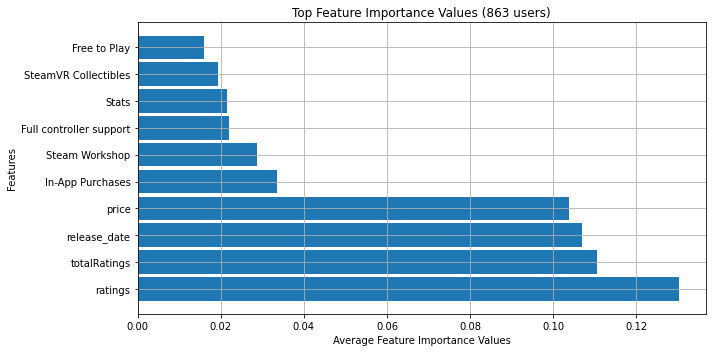

Total Random Forests: 863
Total RMSE: 8420527.472008146
Average RMSE: 9757.274011596925


In [52]:
def drawFeatureChart(featuresDict, numTopFeatures=10):
    # creating the dataset
    fig = plt.figure(figsize = (10, 5))
    sortedFeatureImportanceDict = dict(sorted(featureImportanceDict.items(), key=lambda item: item[1], reverse=True))
    plt.barh(list(sortedFeatureImportanceDict.keys())[:numTopFeatures], list(sortedFeatureImportanceDict.values())[:numTopFeatures], height = 0.875)
    plt.xlabel("Average Feature Importance Values")
    plt.ylabel("Features")
    plt.grid()
    plt.title("Top Feature Importance Values (" + str(num_random_forest_runs) + " users)")
    plt.tight_layout()
    plt.savefig('TopFeatures' + str(num_random_forest_runs) + '.png', dpi = 400)
    plt.show()

for key in featureImportanceDict.keys():
    featureImportanceDict[key] /= num_random_forest_runs

drawFeatureChart(featureImportanceDict)
print("Total Random Forests:", num_random_forest_runs)
print("Total RMSE:", rmse_sum)
print("Average RMSE:", rmse_sum / num_random_forest_runs)